# Worlds Stats Breakdown

- Overall Winrates for Corp and Runner
- Winrates by Matchup
- What do the distribution of places look like for each ID
- What Corps/Runners overperformed in cut representation

In [1]:
import pandas as pd
import requests
import warnings
import netrunner_utils as nu

warnings.simplefilter(action="ignore", category=FutureWarning)
import jupyter_black

jupyter_black.load()

In [2]:
worlds_players, worlds_matches, worlds_elim = nu.get_tournament_dataframes(3181)

In [3]:
worlds_matches.columns

Index(['round', 'table', 'intentionalDraw', 'twoForOne', 'eliminationGame',
       'player1.id', 'player1.runnerScore', 'player1.corpScore',
       'player1.combinedScore', 'player2.id', 'player2.runnerScore',
       'player2.corpScore', 'player2.combinedScore', 'player1.role',
       'player1.winner', 'player2.role', 'player2.winner'],
      dtype='object')

In [5]:
swiss_winrates = nu.get_winrates_swiss(matches=worlds_matches, players=worlds_players)
swiss_winrates["corp_wins"] / (
    swiss_winrates["corp_wins"] + swiss_winrates["runner_wins"]
)

0.5741469816272966

In [14]:
elim_matches = worlds_matches[worlds_matches["eliminationGame"]].copy()

elim_matches["winning_side"] = elim_matches.apply(
    lambda row: row["player1.role"] if row["player1.winner"] else row["player2.role"],
    axis=1,
)
elim_matches.groupby("winning_side").size()["corp"]

12

In [8]:
def get_winner(corp_score, runner_score):
    if corp_score > runner_score:
        return "corp"
    elif runner_score > corp_score:
        return "runner"
    else:
        return "draw"


def get_matchup_spread(tid: str) -> pd.DataFrame:
    matches, players, elim_rankings = get_tournament_tables(tid)

    swiss_played_games = matches[
        (matches["intentionalDraw"] == False)
        & (matches["twoForOne"] == False)
        & (matches["eliminationGame"] == False)
    ]
    aug_scores = pd.merge(
        swiss_played_games[["id", "runnerScore", "corpScore", "round", "table"]],
        players[["id", "corpIdentity", "runnerIdentity"]],
        on="id",
        how="left",
    )
    aug_scores = pd.merge(
        aug_scores,
        aug_scores,
        on=["round", "table"],
        suffixes=("_left", "_right"),
    )
    aug_scores = aug_scores[aug_scores["id_left"] < aug_scores["id_right"]]
    match_dict = []
    for index, match_pair in aug_scores.iterrows():
        try:
            match_dict.append(
                {
                    "corp": match_pair["corpIdentity_left"],
                    "runner": match_pair["runnerIdentity_right"],
                    "result": get_winner(
                        match_pair["corpScore_left"], match_pair["runnerScore_right"]
                    ),
                }
            )
        except:
            print(index)
        try:
            match_dict.append(
                {
                    "corp": match_pair["corpIdentity_right"],
                    "runner": match_pair["runnerIdentity_left"],
                    "result": get_winner(
                        match_pair["corpScore_right"],
                        match_pair["runnerScore_left"],
                    ),
                }
            )
        except:
            print(index)
    matchup_spread = (
        pd.DataFrame(match_dict)
        .groupby(["corp", "runner", "result"])
        .size()
        .reset_index()
        .pivot_table(index=["corp", "runner"], columns="result", values=0)
        .fillna(0)
        .rename(columns={"corp": "corp_wins", "runner": "runner_wins", "draw": "draws"})
        .reset_index()
    )
    return matchup_spread

In [1]:
import seaborn as sns

matchup_results = get_matchup_spread("3181")
matchup_results["total_games_decisive"] = (
    matchup_results["corp_wins"] + matchup_results["runner_wins"]
)
matchup_results["corp_winrate"] = matchup_results["corp_wins"] / (
    matchup_results["corp_wins"] + matchup_results["runner_wins"]
)

matchup_results
# g = sns.heatmap(
#     data=matchup_results[matchup_results["total_games_decisive"] > 5].pivot(
#         "corp", "runner", "corp_winrate"
#     ),
#     cmap="vlag",
#     # annot=True,
#     annot=matchup_results[matchup_results["total_games_decisive"] > 5].pivot(
#         "corp", "runner", "total_games_decisive"
#     ),
#     cbar_kws={"label": "Corp Win Rate", "ticks": [0, 0.25, 0.5, 0.75, 1]},
#     vmin=0,
#     vmax=1,
# )
# g.set_title("Worlds '23 Corp Win Rates (Number is Total Decisive Games)")

NameError: name 'get_matchup_spread' is not defined

In [10]:
matchup_results.query("corp == 'Near-Earth Hub: Broadcast Center'").sort_values(
    "corp_winrate", ascending=False
)

result,corp,runner,corp_wins,draws,runner_wins,total_games_decisive,corp_winrate
132,Near-Earth Hub: Broadcast Center,419: Amoral Scammer,4.0,0.0,0.0,4.0,1.000000
133,Near-Earth Hub: Broadcast Center,Alice Merchant: Clan Agitator,1.0,1.0,0.0,1.0,1.000000
135,Near-Earth Hub: Broadcast Center,Captain Padma Isbister: Intrepid Explorer,1.0,0.0,0.0,1.0,1.000000
140,Near-Earth Hub: Broadcast Center,Mercury: Chrome Libertador,2.0,0.0,0.0,2.0,1.000000
143,Near-Earth Hub: Broadcast Center,"Rielle ""Kit"" Peddler: Transhuman",1.0,0.0,0.0,1.0,1.000000
144,Near-Earth Hub: Broadcast Center,Tāo Salonga: Telepresence Magician,3.0,1.0,0.0,3.0,1.000000
145,Near-Earth Hub: Broadcast Center,Zahya Sadeghi: Versatile Smuggler,2.0,0.0,0.0,2.0,1.000000
134,Near-Earth Hub: Broadcast Center,Arissana Rocha Nahu: Street Artist,18.0,2.0,1.0,19.0,0.947368
136,Near-Earth Hub: Broadcast Center,Esâ Afontov: Eco-Insurrectionist,13.0,4.0,1.0,14.0,0.928571
138,Near-Earth Hub: Broadcast Center,Hoshiko Shiro: Untold Protagonist,34.0,6.0,11.0,45.0,0.755556


In [11]:
worlds_players.head()

,id,name,rank,corpIdentity,runnerIdentity,matchPoints,strengthOfSchedule,extendedStrengthOfSchedule,stripped_title_x,corpFaction,stripped_title_y,runnerFaction
0,35258,Bridgeman,1,Jinteki: Restoring Humanity,Hoshiko Shiro: Untold Protagonist,42,3.761904761904761111111111111111111111,3.518179082332521111111111111111111111,Jinteki: Restoring Humanity,jinteki,Hoshiko Shiro: Untold Protagonist,anarch
1,35194,cableCarnage,2,Near-Earth Hub: Broadcast Center,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",42,3.606481481481481111111111111111111111,3.382458847736624444444444444444444444,Near-Earth Hub: Broadcast Center,nbn,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",criminal
2,35212,lostgeek,3,Near-Earth Hub: Broadcast Center,Esâ Afontov: Eco-Insurrectionist,42,3.574074074074073333333333333333333333,3.507275132275132222222222222222222222,Near-Earth Hub: Broadcast Center,nbn,NaN,NaN
3,35434,ryanbantwins,4,Ob Superheavy Logistics: Extract. Export. Excel.,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",42,3.470679012345678888888888888888888889,3.426268861454045555555555555555555556,Ob Superheavy Logistics: Extract. Export. Excel.,weyland-consortium,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",criminal
4,35193,Cahuita,5,Haas-Bioroid: Precision Design,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",39,4.111111111111111111111111111111111111,3.494366059180873333333333333333333333,Haas-Bioroid: Precision Design,haas-bioroid,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",criminal


In [12]:
worlds_players.groupby("corpIdentity").size().sort_values(ascending=False)

corpIdentity
Asa Group: Security Through Vigilance               37
Haas-Bioroid: Precision Design                      36
Ob Superheavy Logistics: Extract. Export. Excel.    34
The Outfit: Family Owned and Operated               32
NBN: Reality Plus                                   24
Near-Earth Hub: Broadcast Center                    19
Jinteki: Personal Evolution                         18
Azmari EdTech: Shaping the Future                   10
A Teia: IP Recovery                                  8
Jinteki: Restoring Humanity                          8
Weyland Consortium: Built to Last                    4
AgInfusion: New Miracles for a New World             4
SSO Industries: Fueling Innovation                   3
Sportsmetal: Go Big or Go Home                       3
Thule Subsea: Safety Below                           3
Issuaq Adaptics: Sustaining Diversity                2
Pravdivost Consulting: Political Solutions           2
Epiphany Analytica: Nations Undivided               

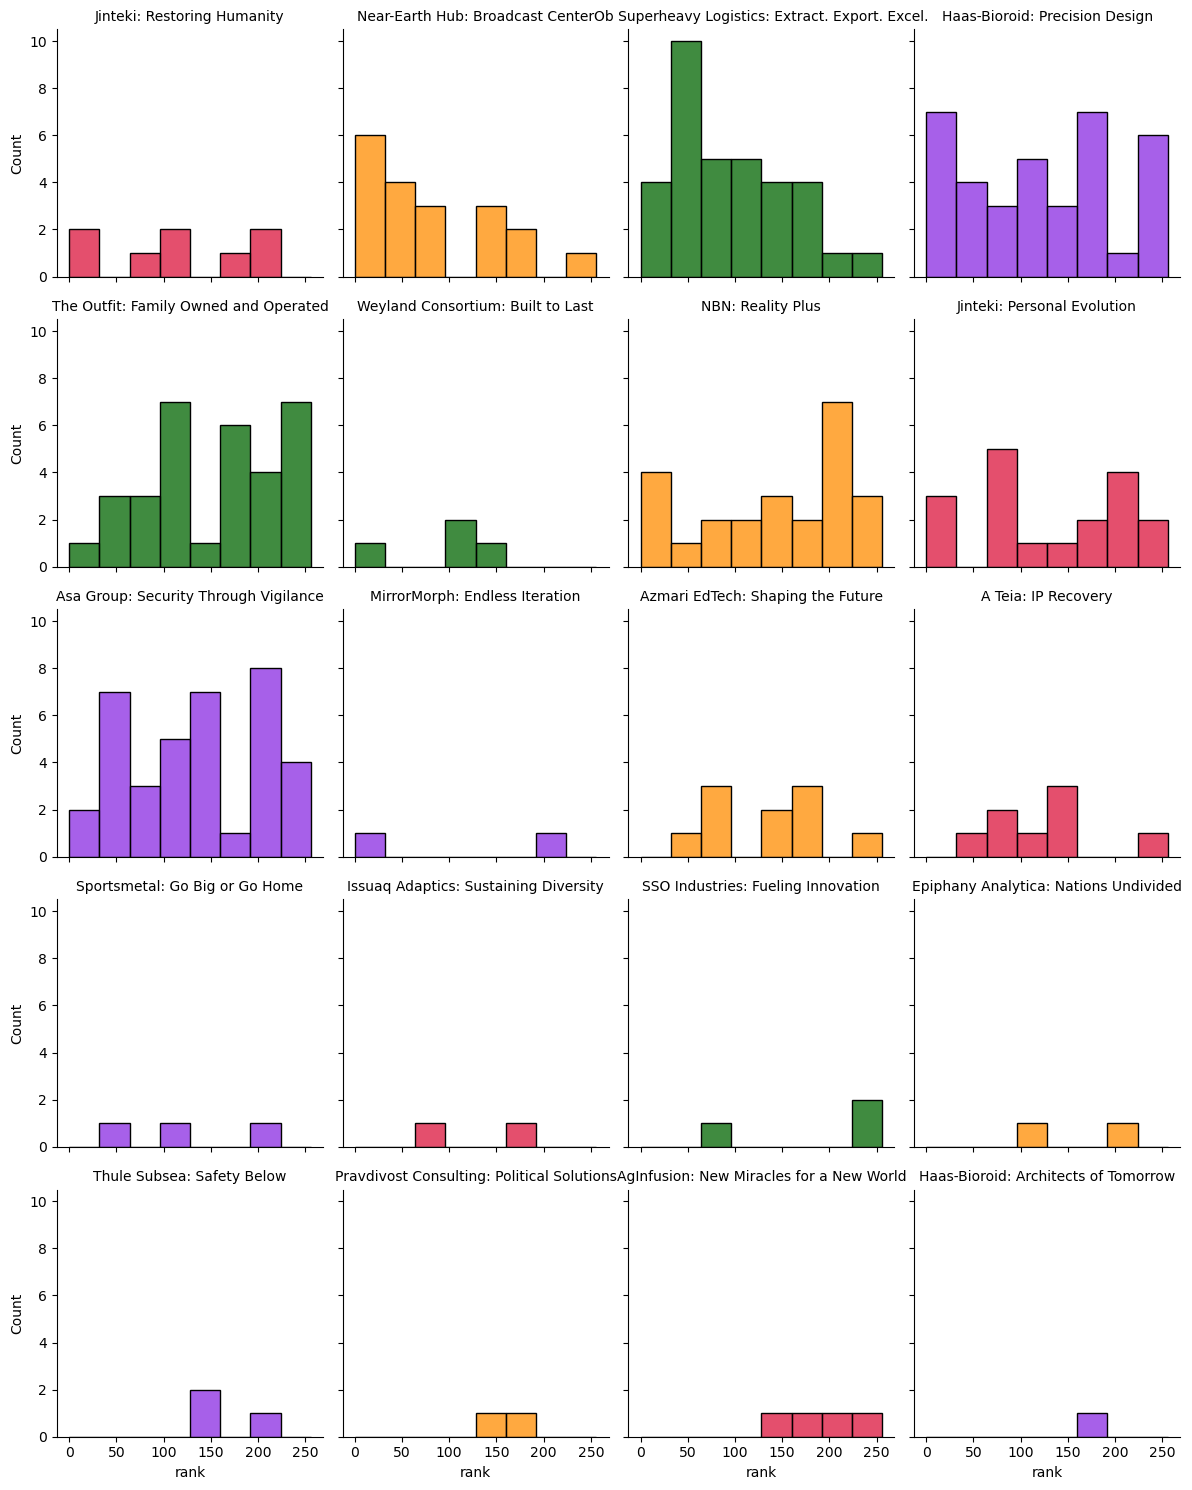

In [13]:
g = sns.FacetGrid(
    data=worlds_players,
    col="corpIdentity",
    col_wrap=4,
    hue="corpFaction",
    palette=faction_hues,
)
g.map(sns.histplot, "rank", bins=[0, 32, 64, 96, 128, 160, 192, 224, 256])
g.set_titles("{col_name}")

Fooling around with Bootstrapping

In [14]:
cut_counts = (
    worlds_players.query("rank < 17")
    .groupby("corpIdentity")
    .size()
    .sort_values()
    .reset_index()
    .rename(columns={0: "count"})
)
swiss_counts = (
    worlds_players.groupby("corpIdentity")
    .size()
    .sort_values()
    .reset_index()
    .rename(columns={0: "count"})
)
swiss_counts["ExpectedCounts"] = swiss_counts["count"] * 16 / worlds_players.shape[0]
swiss_counts = pd.merge(swiss_counts, cut_counts, on="corpIdentity", how="left").fillna(
    0
)
swiss_counts.rename(columns={"count_x": "Swiss", "count_y": "Cut"}, inplace=True)

In [22]:
swiss_counts["individual_chi"] = (
    swiss_counts["Cut"] - swiss_counts["ExpectedCounts"]
) ** 2 / swiss_counts["ExpectedCounts"]
swiss_counts.sort_values("individual_chi", ascending=False)
import scipy.stats as stats

swiss_counts["CDF"] = swiss_counts["individual_chi"].apply(
    lambda x: 1 - stats.chi2.cdf(x, 1)
)
swiss_counts

,corpIdentity,Swiss,ExpectedCounts,Cut,individual_chi,CDF
0,Haas-Bioroid: Architects of Tomorrow,1,0.062992,0.0,0.062992,0.801828
1,Epiphany Analytica: Nations Undivided,2,0.125984,0.0,0.125984,0.722633
2,Pravdivost Consulting: Political Solutions,2,0.125984,0.0,0.125984,0.722633
3,Issuaq Adaptics: Sustaining Diversity,2,0.125984,0.0,0.125984,0.722633
4,MirrorMorph: Endless Iteration,2,0.125984,0.0,0.125984,0.722633
5,Sportsmetal: Go Big or Go Home,3,0.188976,0.0,0.188976,0.663770
6,SSO Industries: Fueling Innovation,3,0.188976,0.0,0.188976,0.663770
7,Thule Subsea: Safety Below,3,0.188976,0.0,0.188976,0.663770
8,Weyland Consortium: Built to Last,4,0.251969,1.0,2.220719,0.136170
9,AgInfusion: New Miracles for a New World,4,0.251969,0.0,0.251969,0.615692
